In [13]:
import json
from gensim.models import KeyedVectors
import numpy as np
import random

In [14]:
# loading word list
with open("korean_frequency.json", encoding="utf-8") as f:
  data = json.load(f)

# list concatenating
word_list = sorted({w for group in data.values() for w in group})
word_list

['가게',
 '가격',
 '가구',
 '가까워지다',
 '가까이',
 '가깝다',
 '가꾸다',
 '가끔',
 '가난',
 '가난하다',
 '가늘다',
 '가능',
 '가능성',
 '가능하다',
 '가능해지다',
 '가다',
 '가득',
 '가득하다',
 '가득히',
 '가라앉다',
 '가려지다',
 '가령',
 '가로',
 '가로등',
 '가로막다',
 '가로수',
 '가루',
 '가르다',
 '가르치다',
 '가르침',
 '가리다',
 '가리키다',
 '가만',
 '가만있다',
 '가만히',
 '가뭄',
 '가방',
 '가볍다',
 '가사',
 '가상',
 '가수',
 '가스',
 '가슴',
 '가슴속',
 '가요',
 '가운데',
 '가위',
 '가을',
 '가이드',
 '가입',
 '가입자',
 '가입하다',
 '가장',
 '가정',
 '가정교사',
 '가져가다',
 '가져다주다',
 '가져오다',
 '가족',
 '가죽',
 '가지',
 '가지다',
 '가짜',
 '가치',
 '가치관',
 '가톨릭',
 '가하다',
 '각각',
 '각국',
 '각기',
 '각오',
 '각자',
 '각종',
 '간격',
 '간단하다',
 '간단히',
 '간부',
 '간섭',
 '간식',
 '간신히',
 '간장',
 '간접',
 '간접적',
 '간판',
 '간편하다',
 '간호',
 '간호사',
 '간혹',
 '갇히다',
 '갈다',
 '갈등',
 '갈비',
 '갈비탕',
 '갈색',
 '갈수록',
 '갈아입다',
 '갈아타다',
 '갈증',
 '감각',
 '감기',
 '감다',
 '감독',
 '감동',
 '감동적',
 '감사',
 '감사하다',
 '감상',
 '감상하다',
 '감소',
 '감소되다',
 '감소하다',
 '감수성',
 '감싸다',
 '감옥',
 '감자',
 '감정',
 '감정적',
 '감추다',
 '감히',
 '갑자기',
 '갑작스럽다',
 '값싸다',
 '강남',
 '강당',
 '강도',
 '강력하다',
 '강력히',
 '강렬하다',
 '강물',
 '강

In [15]:
# loading FastText model
model = KeyedVectors.load("cc.ko.300.kv")

In [16]:
# updating candidates
def update_candidates(candidates, guess, similarity, tolerance = 5.0):
  new_candidates = []
  for cand in candidates:
    if cand not in model or guess not in model:
      continue
    sim = model.similarity(cand, guess) * 100
    if abs(sim - similarity) <= tolerance:
      new_candidates.append(cand)
  return new_candidates
  
# selecting best
def select_best_guess(candidates, tried):
    max_entropy = -1
    best_word = None
    for word in candidates:
        if word not in model:
            continue
        sims = []
        for other in tried:
            if other in model:
                sims.append(model.similarity(word, other))
        entropy = -np.sum(np.log(np.clip(sims, 1e-5, 1))) if sims else 0
        if entropy > max_entropy:
            max_entropy = entropy
            best_word = word
    return best_word or random.choice(candidates)

In [17]:
def simulate_game(answer):
    candidates = [w for w in word_list if w in model]
    tried = []
    for step in range(1, 21):
        guess = select_best_guess(candidates, tried)
        tried.append(guess)

        if guess == answer:
            print(f"✅ 정답 '{guess}'을 {step}번 만에 맞췄습니다!")
            return tried

        similarity = model.similarity(guess, answer) * 100
        print(f"{step}. '{guess}' → 유사도: {similarity:.2f}")
        candidates = update_candidates(candidates, guess, similarity)

    print("❌ 실패: 20회 이내에 정답을 찾지 못했습니다.")
    return tried

In [18]:
simulate_game("사랑스럽다")

1. '가게' → 유사도: 0.45
2. '가입자' → 유사도: -3.68
3. '거칠다' → 유사도: 35.18
4. '자랑하다' → 유사도: 23.63
5. '힘차다' → 유사도: 27.99
✅ 정답 '사랑스럽다'을 6번 만에 맞췄습니다!


['가게', '가입자', '거칠다', '자랑하다', '힘차다', '사랑스럽다']

In [37]:
# 전체 성능 평가
import pandas as pd
def evaluate_model(sample_size=20):
    valid_words = [w for w in word_list if w in model]
    sampled_answers = sampled_answers = [
    '넉넉하다', '익히다', '녹색', '운전자', '오랫동안',
    '소프트웨어', '광고', '찾아오다', '흥분하다', '도심',
    '이제야', '끊다', '실정', '월급', '발견',
    '기운', '교육', '빌다', '신선하다', '끝나다',
    '이야기', '기록', '그릇', '대답', '출근'
]

    results = []
    for ans in sampled_answers:
        tried = simulate_game(ans)
        found = tried[-1] == ans
        results.append({
            'answer': ans,
            'steps': len(tried),
            'success': found
        })

    return pd.DataFrame(results)

1. '가게' → 유사도: 5.84
2. '가치관' → 유사도: 1.44
3. '전달하다' → 유사도: 13.30
4. '귀하다' → 유사도: 45.07
5. '파랗다' → 유사도: 23.96
✅ 정답 '넉넉하다'을 6번 만에 맞췄습니다!
1. '가게' → 유사도: 7.06
2. '따스하다' → 유사도: 14.37
3. '정치적' → 유사도: -3.56
4. '등록하다' → 유사도: 18.03
5. '엊그제' → 유사도: 7.41
6. '창조하다' → 유사도: 33.60
✅ 정답 '익히다'을 7번 만에 맞췄습니다!
1. '가게' → 유사도: 11.79
2. '가르다' → 유사도: 4.75
3. '지적' → 유사도: 13.45
4. '우선' → 유사도: 20.12
5. '학생' → 유사도: 28.07
6. '개별' → 유사도: 15.05
7. '학번' → 유사도: 16.81
8. '불교' → 유사도: 19.74
9. '초보' → 유사도: 14.69
✅ 정답 '녹색'을 10번 만에 맞췄습니다!
1. '가게' → 유사도: 0.79
2. '간단하다' → 유사도: 4.56
3. '역사학' → 유사도: 5.85
4. '수도권' → 유사도: 12.11
5. '무궁화' → 유사도: 5.66
6. '관심사' → 유사도: 13.96
7. '깨소금' → 유사도: 5.50
8. '자연적' → 유사도: 10.80
9. '신제품' → 유사도: 8.27
10. '인원' → 유사도: 18.31
✅ 정답 '운전자'을 11번 만에 맞췄습니다!
1. '가게' → 유사도: 1.73
2. '간단하다' → 유사도: 14.67
3. '수동적' → 유사도: -1.53
4. '한평생' → 유사도: 31.36
✅ 정답 '오랫동안'을 5번 만에 맞췄습니다!
1. '가게' → 유사도: 12.92
2. '인하다' → 유사도: -2.18
3. '중얼거리다' → 유사도: 9.41
4. '시청자' → 유사도: 12.93
5. '활발히' → 유사도: 4.52
6. '할머니' → 유사도: 4.21
7. '사물' → 유사

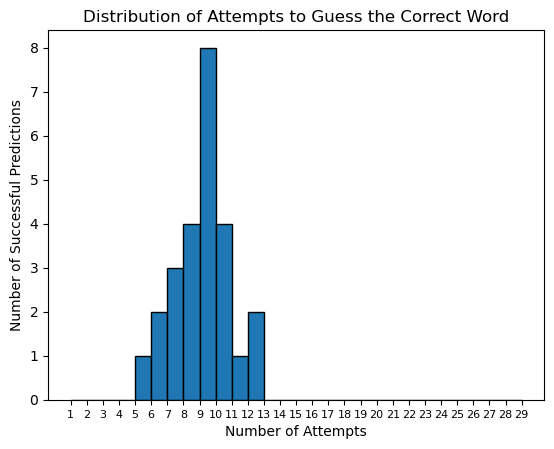

Average Number of Attempts: 8.68
Success Rate: 100.0%


In [40]:
# 평가 및 시각화
import matplotlib.pyplot as plt

random.seed(42)
df = evaluate_model(30)

plt.figure()
plt.hist(df['steps'], bins=range(1, 30), edgecolor='black')
plt.xticks(np.arange(1, 30, 1), fontsize=8)
plt.xlabel("Number of Attempts")
plt.ylabel("Number of Successful Predictions")
plt.title("Distribution of Attempts to Guess the Correct Word")
plt.show()

avg_steps = df['steps'].mean()
success_rate = df['success'].mean() * 100
print(f"Average Number of Attempts: {avg_steps:.2f}")
print(f"Success Rate: {success_rate:.1f}%")